In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import my_statistics as ms
import seaborn as sns
import sklearn.tree
from tqdm.notebook import tqdm
import copy
import decision_trees_class as dtc
import random

In [2]:
hitters = pd.read_csv('Gradivo/Hitters.csv')

In [3]:
hitters.head(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N


In [4]:
hitters.dropna(axis=0, subset=['Salary'], inplace=True)

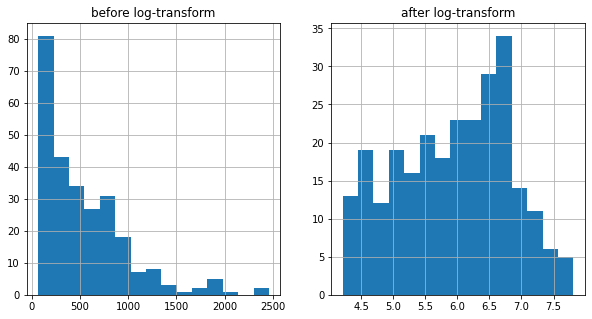

In [5]:
# salary log transform
salary_log = np.log(hitters.Salary)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(x = hitters.Salary, bins=15)
ax[0].set_title('before log-transform')
ax[0].grid()
ax[1].hist(x = salary_log, bins=15)
ax[1].set_title('after log-transform')
ax[1].grid()

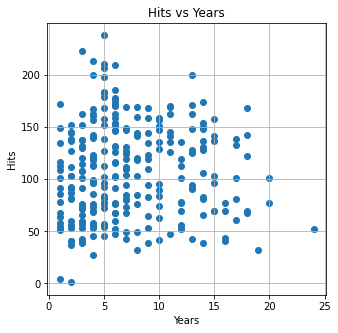

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(hitters.Years, hitters.Hits)
plt.title('Hits vs Years')
plt.xlabel('Years')
plt.ylabel('Hits')
plt.grid()

###  Recursive binary splitting

In [7]:
hitters_num = hitters.loc[:,hitters.dtypes == 'int64']

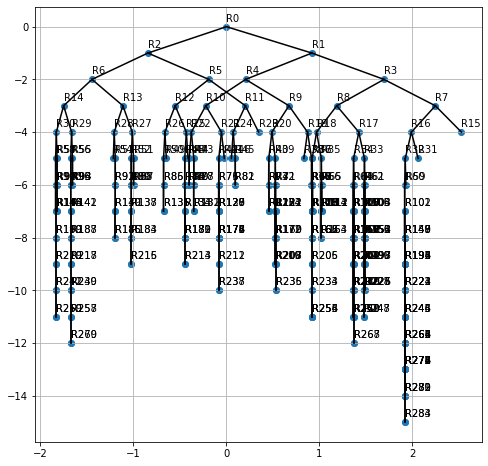

In [8]:
features = ['Hits', 'Runs', 'Walks', 'Years', 'RBI']
r_size=3
tree = dtc.DecisionTree(training_inputs = hitters_num[features],
                        training_outputs = salary_log,
                        s_div=30,
                        max_leaf_size=r_size,
                        criterion = 'RSS')
tree.plot_tree()

In [9]:
pred, cl_pred = tree.predict(hitters_num[features])

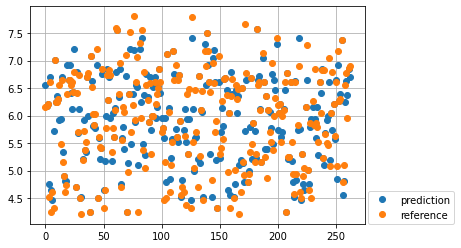

In [10]:
plt.plot(np.arange(len(pred)), pred,'o', label='prediction')
plt.plot(np.arange(len(pred)), salary_log,'o', label='reference')
plt.legend(loc=(1.01,0))
plt.grid()

In [11]:
# predictions for different R size limits
features = ['Hits', 'Runs', 'Walks', 'Years', 'RBI']
errors, predictions, refs = {}, {}, {}
r_list = [50, 30, 10, 5, 3]
for r_size in tqdm(r_list):
    my_tree_r = dtc.DecisionTree(hitters_num[features], salary_log, s_div=100,
                             max_leaf_size=r_size, criterion='RSS')
    y_pred_r, y_cl_r = my_tree_r.predict(hitters_num[features])
    dif = abs(salary_log - y_pred_r)
    errors[r_size], predictions[r_size] = dif, y_pred_r

  0%|          | 0/5 [00:00<?, ?it/s]

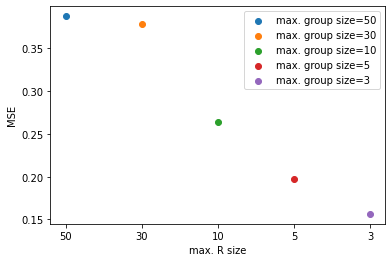

In [12]:
# MSE for different R size limits
for i,j in enumerate(r_list):
    plt.scatter(i, ms.MSE(predictions[j], salary_log),
                label=f'max. group size={j}')
plt.xticks(np.arange(len(r_list)), r_list)
plt.legend()
plt.xlabel('max. R size')
plt.ylabel('MSE');

(0.0, 100.0)

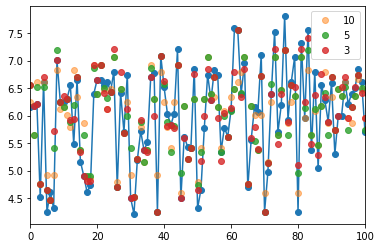

In [13]:
# predictions for different R sizes
plt.plot(np.arange(len(salary_log)), salary_log,'-o')
#plt.plot(np.arange(len(predictions[50])), predictions[50],'o', label=50)
#plt.plot(np.arange(len(predictions[30])), predictions[30], 'o', label=30,alpha=.5)
plt.plot(np.arange(len(predictions[10])), predictions[10], 'o', label=10, alpha=.5)
plt.plot(np.arange(len(predictions[5])), predictions[5], 'o', label=5, alpha=.8)
plt.plot(np.arange(len(predictions[3])), predictions[3], 'o', label=3, alpha=.8)
plt.legend()
plt.xlim(0,100)

### Determining $\alpha$ values and treesizes for tree pruning purpuses

In [14]:
tree_scores_alpha, tree_sizes_l = [], []
alpha_array = np.linspace(0,0.5,10)
for alpha in tqdm(alpha_array):
    tree_scores, tree_sizes = tree.tree_pruning(alpha=alpha, all_=True)
    tree_scores_alpha.append(tree_scores)
    tree_sizes_l.append(tree_sizes)

  0%|          | 0/10 [00:00<?, ?it/s]

α_0; tree score min = 41.471110302678454, tree size = 143
α_1; tree score min = 49.4155547471229, tree size = 143
α_2; tree score min = 57.35999919156734, tree size = 143
α_3; tree score min = 65.26797604491601, tree size = 142
α_4; tree score min = 73.12860534892049, tree size = 141
α_5; tree score min = 80.68977539176439, tree size = 135
α_6; tree score min = 88.18977539176439, tree size = 135
α_7; tree score min = 91.57556075362325, tree size = 25
α_8; tree score min = 92.85252411010605, tree size = 16
α_9; tree score min = 93.74141299899493, tree size = 16


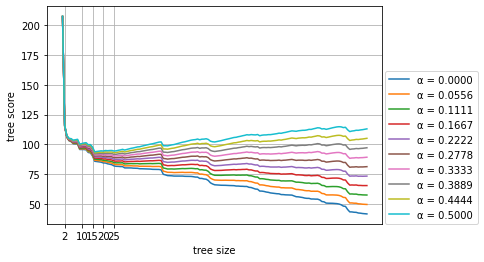

In [15]:
for i,j in enumerate(alpha_array):
    plt.plot(tree_sizes_l[i], tree_scores_alpha[i], label=f'α = {j:.4f}')
    min_ind = np.argmin(tree_scores_alpha[i])
    print(f'α_{i}; tree score min = {tree_scores_alpha[i][min_ind]}, tree size = {tree_sizes_l[i][min_ind]}')
plt.legend(loc = (1.01, 0))
plt.ylabel('tree score')
plt.xlabel('tree size')
plt.xticks(ticks=[2,10,15,20,25])
plt.grid()

In [16]:
# find alphas and corresponding tree sizes
alphas, sizes = tree.find_alphas(alpha_range=np.linspace(0,0.5,10))

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
# k-fold CV
features = ['Hits', 'Runs', 'Walks', 'Years', 'RBI']
r_size=3
errors =  dtc.k_fold_CV_for_decision_tree_pruning(hitters_num[features], 
                                                 salary_log, k=5,
                                                 alpha=alphas,
                                                 sizes=sizes, r_size=r_size,
                                                 criterion='RSS')

Main loop:   0%|          | 0/6 [00:00<?, ?it/s]

loop for α = 0.0000:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.1667:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.2222:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.2778:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.3889:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.4444:   0%|          | 0/5 [00:00<?, ?it/s]

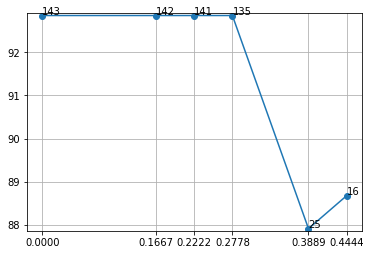

In [18]:
plt.plot(alphas, errors, '-o')
for i in range(len(alphas)):
    plt.annotate(sizes[i], (alphas[i], errors[i]+0.02))
plt.grid()
plt.ylim(min(errors)-0.05, max(errors)+0.05)
plt.xticks(alphas);

In [19]:
tree = dtc.DecisionTree(hitters_num[features], salary_log, s_div=100,
                        max_leaf_size=r_size, criterion='RSS')
tree.shrink_tree(size_goal=sizes[4])
y_pred, cl_pred = tree.predict(hitters_num[features])

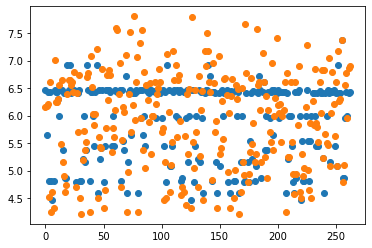

In [20]:
plt.plot(np.arange(len(y_pred)), y_pred,'o')
plt.plot(np.arange(len(y_pred)), salary_log,'o')
#plt.xlim(0,50)

##### Decision trees using sklearn

In [21]:
reg_tree = sklearn.tree.DecisionTreeRegressor()
reg_tree_fit = reg_tree.fit(hitters_num, hitters.Salary)

In [22]:
sklearn_pred = reg_tree_fit.predict(hitters_num)

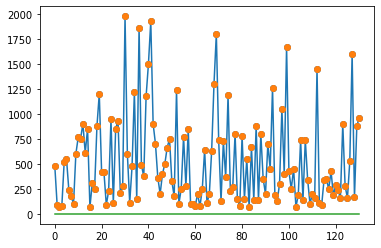

In [23]:
plt.plot(np.arange(131), reg_tree_fit.predict(hitters_num[1::2]),'-o')
plt.plot(np.arange(131),hitters.Salary[1::2],'o')
plt.plot(np.arange(131), reg_tree_fit.predict(hitters_num[1::2])- hitters.Salary[1::2])

### Classification Trees

In [24]:
h_df = pd.read_csv('Gradivo/Heart.csv')
h_df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [25]:
h_df.head(2)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes


In [26]:
HD_dummy = np.zeros(h_df.shape[0])
HD_dummy[h_df.AHD == 'Yes'], HD_dummy[h_df.AHD == 'No'] = 1, 0

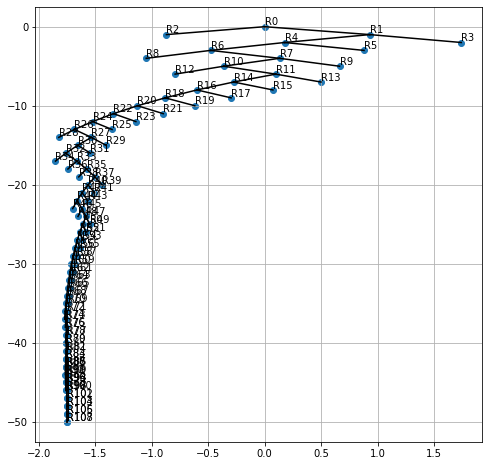

In [47]:
features = ['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
            'ExAng', 'Oldpeak', 'Slope', 'Ca']
class_tree = dtc.DecisionTree(h_df[features], HD_dummy, s_div=30,
                              max_leaf_size=30, criterion='Gini')
class_tree.plot_tree()

In [63]:
# cunfusion matrix for seen data
y_cl_pred, y_cl = class_tree.predict(h_df[features][::2])
ms.confusion_matrix(y_cl_pred, HD_dummy[::2], print_=True);

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 70       |         FN = 12       |  82  |
|     Yes     |         FP = 10       |         TP = 60       |  70  |
|             | specificity = 87.50 % | sensitivity = 83.33 % |      |
|     Sums    |           82          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+


In [65]:
print(f'Error rate: {ms.classification_error_rate(y_cl_pred, HD_dummy[::2]):.3f}')

Error rate: 0.145


In [66]:
y_cl_pred, y_cl = class_tree.predict(h_df[features][1::2])
ms.confusion_matrix(y_cl_pred, HD_dummy[1::2], print_=True);

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 80       |         FN = 10       |  90  |
|     Yes     |         FP = 4        |         TP = 57       |  61  |
|             | specificity = 95.24 % | sensitivity = 85.07 % |      |
|     Sums    |           90          |           67          | 151  |
+-------------+-----------------------+-----------------------+------+


In [67]:
print(f'Error rate: {ms.classification_error_rate(y_cl_pred, HD_dummy[1::2]):.3f}')

Error rate: 0.093


In [50]:
tree_scores_alpha, tree_sizes_l = [], []
alpha_array = np.linspace(0,1.5,20)
for alpha in tqdm(alpha_array):
    tree_scores, tree_sizes = class_tree.tree_pruning(alpha=alpha, all_=True)
    tree_scores_alpha.append(tree_scores)
    tree_sizes_l.append(tree_sizes)

  0%|          | 0/20 [00:00<?, ?it/s]

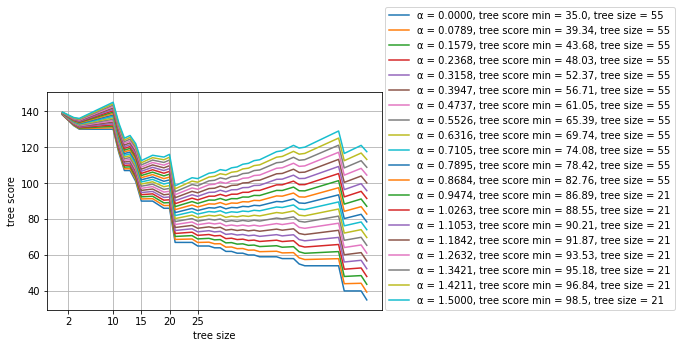

In [51]:
for i,j in enumerate(alpha_array):
    min_ind = np.argmin(tree_scores_alpha[i])
    plt.plot(tree_sizes_l[i], tree_scores_alpha[i],
             label=f'α = {j:.4f}, tree score min = {tree_scores_alpha[i][min_ind]:.4}, tree size = {tree_sizes_l[i][min_ind]}')
    
plt.legend(loc = (1.01, 0))
plt.ylabel('tree score')
plt.xlabel('tree size')
plt.xticks(ticks=[2,10,15,20,25])
plt.grid()

In [52]:
# find alphas and corresponding tree sizes
alphas, sizes = class_tree.find_alphas(alpha_array)

  0%|          | 0/20 [00:00<?, ?it/s]

In [53]:
alphas, sizes

([0.0, 0.9473684210526315], [55, 21])

In [55]:
# k-fold CV
features = ['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
            'ExAng', 'Oldpeak', 'Slope', 'Ca']
r_size=3
errors =  dtc.k_fold_CV_for_decision_tree_pruning(h_df[features], 
                                                 HD_dummy, k=5,
                                                 alpha=alphas,
                                                 sizes=sizes, r_size=r_size,
                                                 criterion='gini')

Main loop:   0%|          | 0/2 [00:00<?, ?it/s]

loop for α = 0.0000:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.9474:   0%|          | 0/5 [00:00<?, ?it/s]

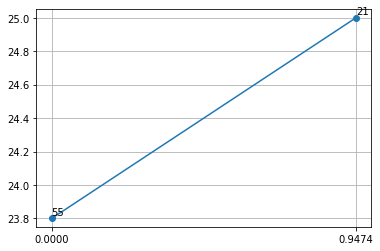

In [56]:
plt.plot(alphas, errors, '-o')
for i in range(len(alphas)):
    plt.annotate(sizes[i], (alphas[i], errors[i]+0.02));
plt.grid()
plt.ylim(min(errors)-0.05, max(errors)+0.05)
plt.xticks(alphas);

In [57]:
class_tree.to_original()
class_tree.shrink_tree(size_goal=40)

In [58]:
# confusion matrix for unseen data
y_cl_pred, y_cl = class_tree.predict(h_df[features][1::2])
ms.confusion_matrix(y_cl_pred, HD_dummy[1::2], print_=True);

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 82       |         FN = 21       | 103  |
|     Yes     |         FP = 2        |         TP = 46       |  48  |
|             | specificity = 97.62 % | sensitivity = 68.66 % |      |
|     Sums    |          103          |           67          | 151  |
+-------------+-----------------------+-----------------------+------+


In [62]:
print(f'Error rate: {ms.classification_error_rate(y_cl_pred, HD_dummy[1::2]):.3f}')

Error rate: 0.152


### Bagging

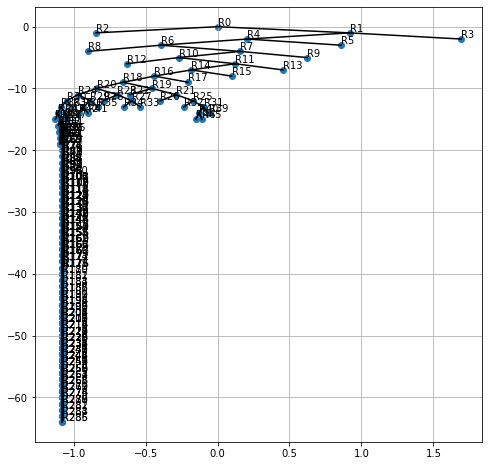

In [77]:
features = ['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
            'ExAng', 'Oldpeak', 'Slope', 'Ca']
class_tree = dtc.DecisionTree(h_df[features], HD_dummy, s_div=30,
                              max_leaf_size=10, criterion='Gini')
class_tree.plot_tree()

In [78]:
class_tree.bagging(B=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [79]:
y_pred_bagging = class_tree.bagging_predict(h_df[features][1::2])
ms.confusion_matrix(y_pred_bagging, HD_dummy[1::2], print_=True);

  0%|          | 0/100 [00:00<?, ?it/s]

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 69       |         FN = 12       |  81  |
|     Yes     |         FP = 15       |         TP = 55       |  70  |
|             | specificity = 82.14 % | sensitivity = 82.09 % |      |
|     Sums    |           81          |           67          | 151  |
+-------------+-----------------------+-----------------------+------+


In [80]:
print(f'Error rate: {ms.classification_error_rate(y_pred_bagging, HD_dummy[1::2]):.3f}')

Error rate: 0.179


In [73]:
# from shrinked to original tree
class_tree.to_original()

In [74]:
class_tree.bagging(B=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [75]:
y_pred_bagging = class_tree.bagging_predict(h_df[features][1::2])
ms.confusion_matrix(y_pred_bagging, HD_dummy[1::2], print_=True);

  0%|          | 0/100 [00:00<?, ?it/s]

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 61       |         FN = 10       |  71  |
|     Yes     |         FP = 23       |         TP = 57       |  80  |
|             | specificity = 72.62 % | sensitivity = 85.07 % |      |
|     Sums    |           71          |           67          | 151  |
+-------------+-----------------------+-----------------------+------+


In [76]:
print(f'Error rate: {ms.classification_error_rate(y_pred_bagging, HD_dummy[1::2]):.3f}')

Error rate: 0.219
